In [1]:
import numpy as np
import math
from functools import reduce
import time
import sys
import os
import numpy as np

path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)
from pathlib import Path
import nidaqmx

def lcm(a, b):
    """Calculate the least common multiple of two numbers."""
    return abs(a * b) // math.gcd(a, b)


def lcm_of_list(numbers):
    """Find the LCM of a list of numbers."""
    return reduce(lcm, numbers)

def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

# some constants
Hz = 1e-9 # GHz
kHz = 1e-6 # GHz
MHz = 1e-3 # GHz
pi = np.pi


In [2]:
import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
from nidaqmx.stream_readers import AnalogSingleChannelReader

from hardware import config as hcf
from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import (
    PulseGenerator,
    OutputState,
    TriggerStart,
    TriggerRearm,
    HIGH,
    LOW,
    INF,
    REPEAT_INFINITELY
)
timebase = lcm_of_list(
    [hcf.VDISYN_timebase, hcf.SIDIG_timebase, hcf.PS_timebase, hcf.RSRF_timebase]
)

hm = HardwareManager()
hm.add_default_hardware()

VDI Sythesizer Serail Port Open
Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


# Some Parameters 
the parameters that will be used in the measurement and need to be set in the GUI


In [3]:
# ---------------------
# Settings for MW
mw_freq = 398.54667  # GHz
mw_hopspan = 2*3.11E-3 # GHz
# mw_hoptime = 1000.0 # ns

mw_powervolt = 0.0  # voltage 0.0 to 5.0
mw_phasevolt = 0.0  # voltage 0.0 to 5.0

# setting for data acquisition
min_volt = -10.0E-3 # [V]
max_volt = 10.0e-3

# setting for laser
laser_current = 95.0  # percentage

# settings for the RF
rf_freq = 600 # MHz

# -------------------
# setting for the sensing sequence
# # nuclear spin preparation
ninit_pihalf = 1000 #ns

# # in a detection block
t_dbloc_idle = 20 # ns
t_dbloc_lock = 3980 # ns
t_dbloc = t_dbloc_idle + t_dbloc_lock

# # in free evolution
t_fevol = 40e3 # [ns] it must be in the multiple of dblock time
n_fevol_div = int(t_fevol // t_dbloc)
t_fevol = n_fevol_div * t_dbloc

n_track = 3000 # repetition of the free evolution + the detection block 
n_dbloc = 2 # how many detection blocks in between free evolution, usually multiple of 2
t_atrack = t_dbloc*n_dbloc + t_fevol
T_alltrack = n_track*t_atrack # [ns] total time = n_track*(free evolution time + detection block time * number of dbloc)


# time_stop = 3600.0*1
time_stop = 6.0
rate_refresh = 10 # 10Hz refreshing rate
# -------------------
paraset = dict(
    mw_freq = mw_freq,
    # mw_hoptime=mw_hoptime,
    mw_hopspan=mw_hopspan,
    mw_powervolt=mw_powervolt,
    mw_phasevolt=mw_phasevolt,
    min_volt=min_volt,
    max_volt=max_volt,
    laser_current=laser_current,
    rf_freq=rf_freq,
    ninit_pihalf=ninit_pihalf,
    t_dbloc_idle=t_dbloc_idle,
    t_dbloc_lock=t_dbloc_lock,
    n_dbloc=n_dbloc,
    t_fevol=t_fevol, 
    n_track=n_track
)

In [4]:
# parameter checking

def check_parameters(paraset):
    assert paraset["mw_powervolt"] <= 5 and paraset["mw_powervolt"]>=0
    assert paraset["mw_phasevolt"] <= 5 and paraset["mw_phasevolt"]>=0
    timeparameters = [
        paraset["t_dbloc_idle"],
        paraset["t_dbloc_lock"], 
        paraset["ninit_pihalf"],
        paraset["t_fevol"]
    ]
    for tt in timeparameters:
        assert tt%timebase == 0

    dblocktimeunit = paraset["t_dbloc_idle"] + paraset["t_dbloc_lock"]
    assert paraset["t_fevol"]%dblocktimeunit == 0
    assert paraset["t_fevol"] >= 2*dblocktimeunit
    assert paraset["ninit_pihalf"]*2 <= dblocktimeunit
check_parameters(paraset)

# apply instruments settings

In [5]:
# -----------------------------------------------------------------------
# set MW power and phase using NIIO ------------------------------------
mwpower_vlevel = paraset["mw_powervolt"]  # 5V equals to max power
task_uca = nidaqmx.Task("UCA")  # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)

mwphase_vlevel = paraset["mw_phasevolt"]  # voltage to phase shifter
task_mwbp = nidaqmx.Task("MW B Phase")  # user controlled attenuation
task_mwbp.ao_channels.add_ao_voltage_chan(hcf.NI_ch_MWBP, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_mwbp.start()
task_mwbp.write([mwphase_vlevel], auto_start=False)

1

In [6]:
"""
TO BE CONTINUE: freqeuncy hopping (2025/01/15)
it seems difficult for the VDI synthesizer to hop bewteen two frequency values only 
while generating a TTL indicating the sweep. so now I focus on the single frequency ODMR first
"""
# # -----------------------------------------------------------------------
# # set MW frequency hopping ---------------------------------------------
# try:
#     hm.mwsyn.open()
# except Exception as ee:
#     print(ee)

# hm.mwsyn.sweep_pause()
# hm.mwsyn.reset_trigger()
# hm.mwsyn.sweep_up()
# freq_start = (paraset["mw_freq"] - paraset["mw_hopspan"] / 2.0) / hcf.VDISYN_multiplier
# freq_stop = (paraset["mw_freq"] + paraset["mw_hopspan"] / 2.0) / hcf.VDISYN_multiplier
# freq_step = paraset["mw_hopspan"] / hcf.VDISYN_multiplier/3.0
# step_min = hm.mwsyn.get_min_step_size([freq_start], [freq_stop])[0]  # in Hz
# freq_step = int(freq_step / step_min * 1e9) * step_min / 1e9

# steptime = paraset["mw_hoptime"]
# steptime = int(steptime / timebase) * timebase
# dwellatlow = False
# dwellathigh = False

# actualpara = hm.mwsyn.sweep(
#     freq_start,
#     freq_stop,
#     freq_step,
#     freq_step,
#     steptime,
#     steptime,
#     dwellatlow,
#     dwellathigh,
# )
# freq_start_actual, freq_stop_actual, step_rise_actual, step_fall_actual = actualpara
# freq_actual_rise = hcf.VDISYN_multiplier * np.arange(
#     freq_start_actual, freq_stop_actual + step_rise_actual, step_rise_actual
# )
# freq_actual_fall = hcf.VDISYN_multiplier * np.flip(
#     np.arange(freq_start_actual + step_rise_actual, freq_stop_actual, step_fall_actual)
# )
# freq_sawsweep = np.append(freq_actual_rise, freq_actual_fall)
# print(freq_sawsweep)
# num_freqsaw = len(freq_sawsweep)
# hm.mwsyn.sweep_continue()


'\nTO BE CONTINUE: freqeuncy hopping (2025/01/15)\nit seems difficult for the VDI synthesizer to hop bewteen two frequency values only \nwhile generating a TTL indicating the sweep. so now I focus on the single frequency ODMR first\n'

In [ ]:
# -----------------------------------------------------------------------
# set the MW frequency --------------------------------------------------
try:
    hm.mwsyn.open()
except Exception as ee:
    print(ee)
mw_freq = paraset["mw_freq"] + paraset["mw_hopspan"]/2.0
freq_actual = hm.mwsyn.cw_frequency(mw_freq / hcf.VDISYN_multiplier)
print(f"CW Freqeuncy Setting Sent:{mw_freq/hcf.VDISYN_multiplier} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.606240833333334 GHz
Actual Output CW Freqeuncy :16.606240835040808 GHz


In [8]:
# -----------------------------------------------------------------------
# set up laser----------------------------------------------------------
current_percent = paraset["laser_current"]
hm.laser.laser_off()
hm.laser.set_analog_control_mode("current")
hm.laser.set_modulation_state("Pulsed")
hm.laser.set_diode_current(current_percent, save_memory=False)

Failed to set command 'ACC=1'
Response from Device :'Not authorized'


## Pulse Sequence for single-point frequency tracking of ODMR with emulated nuclear radio signals

In [9]:
# --------------------------------------------------------------------------------
# set up the pulse sequence ----------------------------------------------------------
# set the channel general offsets--------------------------------------------------
ps_choffs = {
    "laser": 0,
    "dclk": 0.0,
    "dtrig": 160.0,
    "mwA": 0,
    "mwB": 0,
    "rftrig": 0,
    "Bz": 0,  # AO 0
    "Bx": 0,  # AO 1
}
hm.pg.setChOffset(ps_choffs)
# ------------------------------------------------------------------------------
hm.pg.reset()


t_dbloc = paraset["t_dbloc_idle"] + paraset["t_dbloc_lock"]  # one time unit of the detection block
t_dloc_lock = paraset["t_dbloc_lock"]
t_dloc_idle = paraset["t_dbloc_idle"]
t_rf_pihalf = paraset["ninit_pihalf"]
n_track = paraset["n_track"]
n_dbloc = paraset["n_dbloc"]
subseq_ninit = [
    (["rftrig","dtrig"], t_dbloc)
]
t_fevol = paraset["t_fevol"] // t_dbloc * t_dbloc
subseq_fevol = [([], t_fevol)]

t_trig = t_rf_pihalf
t_readat = 400
t_init = t_dbloc
subseq_ninit_ = [(t_init-t_rf_pihalf, LOW), (t_rf_pihalf, HIGH)]
subseq_init_trig = [(t_trig, HIGH), (t_init-t_trig, LOW)]
subseq_init_pad = [(t_init, LOW)] 
subseq_fevol = [(t_fevol, LOW)]
n_fevol_div = int(paraset["t_fevol"]/t_dbloc)
n_half_feve_div = n_fevol_div

subseq_fevol_laser = [(t_dbloc*(n_fevol_div-1), LOW), (t_dbloc, HIGH)]
# subseq_fevol_laser = [(t_dbloc*(n_fevol_div-1), LOW), (t_dbloc, LOW)]
t_dblochalf = int(t_dbloc/2//timebase)*timebase

seq_laser = subseq_init_pad+(subseq_fevol_laser+[(t_dbloc, HIGH)]*n_dbloc)*n_track
# seq_laser = subseq_init_pad+(subseq_fevol_laser+[(t_dbloc, LOW)]*n_dbloc)*n_track
seq_mwA = subseq_init_pad+(subseq_fevol+[(t_dbloc, HIGH)]*n_dbloc)*n_track
# seq_mwA = subseq_init_pad+(subseq_fevol+[(t_dbloc, LOW)]*n_dbloc)*n_track
# seq_dclk = subseq_init_pad + [(t_dbloc-t_dblochalf, LOW), (t_trig, HIGH), (t_dblochalf-t_trig, LOW)]*(n_dbloc+n_fevol_div)*n_track
seq_dclk = subseq_init_pad + [(t_dbloc-t_readat, LOW), (t_readat, HIGH)]*(n_dbloc+n_fevol_div)*n_track
seq_dtrig = subseq_init_trig + [((t_fevol+t_dbloc*n_dbloc)*n_track, LOW)]
seq_rftrig = subseq_init_trig + [((t_fevol+t_dbloc*n_dbloc)*n_track, LOW)]
seq_mwB = seq_mwA

hm.pg.setDigital("laser", seq_laser, offset=True)
hm.pg.setDigital("mwA", seq_mwA, offset=True)
# hm.pg.setDigital("mwB", seq_mwB, offset=True)
hm.pg.setDigital("dclk", seq_dclk, offset=True)
hm.pg.setDigital("dtrig", seq_dtrig, offset=True)
hm.pg.setDigital("rftrig", seq_rftrig, offset=True)


### Fake Nuclear Signal
The emulated signals are based on the assumption that the nuclear driving is much faster than the preccession of the nuclear spins in the rotating frame, such that the magnetic signal align z direction in each detection block is modulated by $\cos(\omega_n t_i)$ where $\omega_n$ is the detuned nuclear Larmor frequency and $t_i$ is the time at the begining of $i$-th detection block. 

$$b_i(t) = b_0 sin(\Omega_{rf} \tau)\cos(\omega t_i+\phi_{noise})$$
where $\tau=t-t_i$ starts from the RF drive in each detection block

In [10]:
# to generate fake signal for testing
amp_a = 0.5
amp_b = 1.0
omega = 2 * pi * (1100 * Hz + 600.0*MHz)
omega_b = 2 * pi * (1200 * Hz + 600.0*MHz)
decay_a = 2*Hz
decay_b = 4*Hz
rfomega = 2 * pi * 80 * kHz
dt_inlock = 200.0
tarray_inlock = np.arange(0, t_dbloc_lock
                        , dt_inlock)
bzlevel0 = np.sin(rfomega*tarray_inlock)
bzlevel0_flip = np.flip(bzlevel0)
i_track = 0
wf_Bz_xpc = []
wf_Bz_xpc += subseq_init_pad
wf_Bz_ypc = []
wf_Bz_ypc += subseq_init_pad
randphase_a = np.random.random(1)*pi
randphase_b = np.random.random(1)*pi
bzevol_cos = np.zeros(n_track)
for it in range(n_track):
    t_evol = t_init + t_atrack*it + t_fevol + t_dbloc_idle
    factor_evol_cos = float(amp_a*np.cos(omega*t_evol+randphase_a)*np.exp(-decay_a*t_evol)+amp_b*np.cos(omega_b*t_evol+randphase_b)*np.exp(-decay_b*t_evol))
    factor_evol_cos /= (amp_a+amp_b)
    # factor_evol_cos *= 0.1
    bzevol_cos[it] = factor_evol_cos
    # factor_evol_sin = amp_a*np.sin(omega*(t_evol+t_dbloc+t_dbloc_idle)+randphase_a)+amp_b*np.sin(omega_b*(t_evol+t_dbloc+t_dbloc_idle)+randphase_b)
    # factor_evol_sin /= (amp_a+amp_b)
    bzlevel_xpc = bzlevel0*factor_evol_cos # X phase cycle
    bzlevel_xpc_flip = bzlevel0_flip*factor_evol_cos
    # bzlevel_ypc = bzlevel0*factor_evol_sin # Y phase cycle
    # bzlevel_ypc_flip = bzlevel0_flip*factor_evol_sin
    # wf_bz_inlock_xpc = [(t_dbloc_idle, 0)]+[(dt_inlock, bzl) for bzl in bzlevel_xpc]
    # wf_bz_inlock_xpc +=  [(t_dbloc_idle, 0)]+[(dt_inlock, bzl) for bzl in bzlevel_xpc_flip]
    # wf_bz_inlock_ypc = [(t_dbloc_idle, 0)]+[(dt_inlock, bzl) for bzl in bzlevel_ypc]
    # wf_bz_inlock_ypc +=  [(t_dbloc_idle, 0)]+[(dt_inlock, bzl) for bzl in bzlevel_ypc_flip]
    # # wf_bz_inlock = [(t_dbloc, 1)]
    # wf_Bz_xpc += [(t_fevol, 0)]+wf_bz_inlock_xpc
    # # wf_Bz_ypc += [(t_fevol, 0)]+wf_bz_inlock_ypc
    wf_Bz_xpc += [(t_atrack, factor_evol_cos)]
    # wf_Bz_ypc += [(t_fevol, 0)]+wf_bz_inlock_ypc


hm.pg.setAnalog("Bz", wf_Bz_xpc, offset=True) 
# hm.pg.setAnalog("Bx", wf_Bz_xpc, offset=True) 

Setting Analog channel 0


C:\Users\ctcheung\AppData\Local\Temp\ipykernel_15896\2216918228.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  factor_evol_cos = float(amp_a*np.cos(omega*t_evol+randphase_a)*np.exp(-decay_a*t_evol)+amp_b*np.cos(omega_b*t_evol+randphase_b)*np.exp(-decay_b*t_evol))


In [11]:
# import plotly.graph_objects as go
# import numpy as np

# # Assuming 'bzevol_cos' and 't_atrack' are defined
# fakesig_fft = np.fft.fft(bzevol_cos)
# fakesig_freq = np.fft.fftfreq(len(fakesig_fft), t_atrack / 1e9)

# # Get only the positive frequencies
# idx_pfreq = fakesig_freq > 0
# positive_freqs = fakesig_freq[idx_pfreq]
# positive_amplitudes = np.abs(fakesig_fft[idx_pfreq])

# # Create a Plotly figure
# fig = go.Figure()

# # Add the FFT data to the figure
# fig.add_trace(go.Scatter(
#     x=positive_freqs,
#     y=positive_amplitudes,
#     mode='lines',
#     name='FFT'
# ))

# # Update layout for better visualization
# fig.update_layout(
#     title="FFT of Emulated Signal (Positive Frequencies)",
#     xaxis_title="Frequency [Hz]",
#     yaxis_title="Amplitude",
#     legend_title="Legend",
#     template="plotly_white",
#     height=400,
#     width=700
# )

# # Show the figure
# fig.show()


In [ ]:
# hm.pg.plotSeq(plot_all=False)

In [13]:
hm.pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
hm.pg.stream(n_runs=REPEAT_INFINITELY)

In [14]:

# set up the data acquisition with NI daq
# signal reading parameters
min_volt = paraset["min_volt"]
max_volt = paraset["max_volt"]
rate_sample = 1.0/t_dbloc/Hz # sampling rate of the NI daq, Hz
num_read_fevol = n_fevol_div
num_read_alldbloc = n_dbloc
num_read_inatrack = num_read_alldbloc + num_read_fevol
num_read_refresh = rate_sample/rate_refresh
num_read_refresh = int(num_read_inatrack*(num_read_refresh//num_read_inatrack))
n_track_refresh = int(num_read_refresh/num_read_inatrack)

num_readsample = n_track*(n_fevol_div+n_dbloc)

timeout_read = max(2*num_read_refresh/rate_sample, 10)
# buffer_size = num_readsample
# buffer_temp = np.zeros(buffer_size, dtype=np.float64, order='C')
buffer_refresh = np.zeros(num_read_refresh, dtype=np.float64, order='C')
buffer_data = np.zeros((n_track, n_dbloc+1), dtype=np.float64, order='C')


In [15]:
readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hcf.NI_ch_APD,"",
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    rate_sample, 
    source=hcf.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [16]:
hm.laser.laser_on() # turn on laser
readtask.start() # ready to read data
hm.pg.startNow()
start_time = time.time()
idx_run = 0
idx_pointer = 0
num_track_readed = 0
num_repeated = np.zeros(n_track)
while time.time() - start_time < time_stop:
    
    idx_pointer = idx_pointer%n_track
    num_read = reader.read_many_sample(buffer_refresh, num_read_refresh, timeout_read)
    # print(num_read==num_read_refresh)
    buffer_refresh_reshape = np.reshape(buffer_refresh, (n_track_refresh, num_read_inatrack))
    if n_track-idx_pointer >= n_track_refresh:
        buffer_data[idx_pointer:idx_pointer+n_track_refresh] += np.copy(buffer_refresh_reshape[:, -(n_dbloc+1):])
        num_repeated[idx_pointer:idx_pointer+n_track_refresh] += 1
    else:
        n_remaining = n_track-idx_pointer
        n_front = n_track_refresh-n_remaining
        buffer_data[idx_pointer:idx_pointer+n_remaining] += np.copy(buffer_refresh_reshape[:n_remaining, -(n_dbloc+1):])
        num_repeated[idx_pointer:idx_pointer+n_remaining] += 1
        buffer_data[:n_front] += np.copy(buffer_refresh_reshape[n_remaining:, -(n_dbloc+1):])
        num_repeated[:n_front] += 1
    idx_pointer += n_track_refresh
    idx_run += 1
    # print(f"Index Pointer: {idx_pointer}, Portion in all tracks: {idx_pointer/n_track}")
for ii in range(n_dbloc+1):
    buffer_data[:, ii] = np.divide(buffer_data[:, ii], num_repeated)

In [17]:
hm.pg.forceFinal()
hm.pg.constant(OutputState.ZERO())
hm.pg.reset()
hm.laser.laser_off()
task_mwbp.close()
task_uca.close()
readtask.close()
hm.mwsyn.close_gracefully()

VDI Synthesizer Serial port closed.


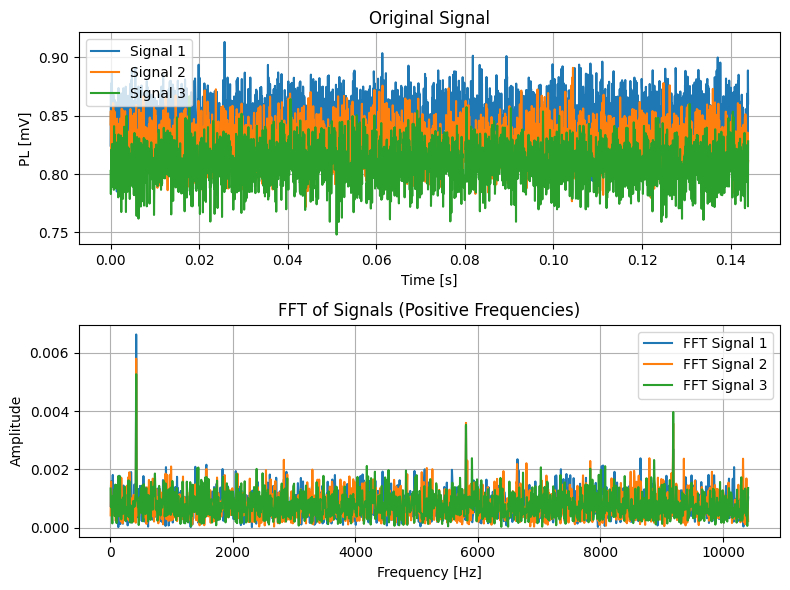

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 't_atrack', 'n_track', and 'buffer_data' are defined
timetime = t_atrack * np.arange(0, n_track, 1) / 1E9

# Create subplots with two columns
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot the original data (time domain)
for ii in range(0, n_dbloc + 1):
    sig_diff = buffer_data[:, ii]
    axes[0].plot(timetime, sig_diff*1E3, label=f"Signal {ii+1}")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("PL [mV]")
axes[0].set_title("Original Signal")
axes[0].legend()
axes[0].grid()
sig_fft_0 =  np.abs(np.fft.fft(buffer_data[:, 0]))

# Plot the FFT (frequency domain, positive frequencies only)
for ii in range(0, n_dbloc + 1):
    sig_diff = buffer_data[:, ii] 
    freq = np.fft.fftfreq(len(sig_diff), t_atrack / 1E9)
    sig_fft = np.abs(np.fft.fft(sig_diff))
    # sig_fft = sig_fft-sig_fft_0

    # Get only positive frequencies
    positive_freqs = freq > 0
    axes[1].plot(freq[positive_freqs], sig_fft[positive_freqs], label=f"FFT Signal {ii+1}")
axes[1].set_xlabel("Frequency [Hz]")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("FFT of Signals (Positive Frequencies)")
axes[1].legend()
axes[1].grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [19]:
import plotly.graph_objects as go
import numpy as np

# Assuming 't_atrack', 'n_track', 'buffer_data', and 'n_dbloc' are defined
timetime = t_atrack * np.arange(0, n_track, 1) / 1E9

# Create a Plotly figure
fig = go.Figure()

# # Plot the original data (time domain)
# for ii in range(0, n_dbloc + 1):
#     sig_diff = buffer_data[:, ii] - buffer_data[:, 0]
#     fig.add_trace(go.Scatter(
#         x=timetime,
#         y=sig_diff,
#         mode='lines',
#         name=f"Signal {ii+1} (Time Domain)"
#     ))

# Plot the FFT (frequency domain, positive frequencies only)
for ii in range(0, n_dbloc + 1):
    sig_diff = buffer_data[:, ii]
    freq = np.fft.fftfreq(len(sig_diff), t_atrack / 1E9)
    sig_fft = np.abs(np.fft.fft(sig_diff))
    # sig_fft = sig_fft-sig_fft_0

    # Get only positive frequencies
    positive_freqs = freq > 0
    fig.add_trace(go.Scatter(
        x=freq[positive_freqs],
        y=sig_fft[positive_freqs],
        mode='lines',
        name=f"Signal {ii+1} (FFT)"
    ))

# Update layout for better readability
fig.update_layout(
    title="Original Signal and FFT",
    xaxis_title="Time [s] / Frequency [Hz]",
    yaxis_title="Amplitude / PL [V]",
    legend_title="Signal Legend",
    grid=dict(rows=2, columns=1, pattern="independent"),
    height=600,
    width=800
)

# Show the Plotly figure
fig.show()


In [20]:
import pickle
# Define the file name
fname = f"data_dev_dressed_nuclear_signal_tracking_20250122_test_{time.time()}.pkl"

# Assuming 'buffer_data' and 'paraset' are defined
data_to_save = {
    "buffer_data": buffer_data,
    "paraset": paraset
}

# Save the data to a pickle file
with open(fname, "wb") as file:
    pickle.dump(data_to_save, file)

print(f"Data successfully saved to {fname}")


Data successfully saved to data_dev_dressed_nuclear_signal_tracking_20250122_test_1737524155.9239554.pkl


In [21]:
with open(fname, "rb") as file:
    loaded_data = pickle.load(file)

buffer_data = loaded_data["buffer_data"]
paraset = loaded_data["paraset"]

# Simulation TBC



In [22]:
# def rotation_matrix(axis, theta):
#     """
#     Compute the 3D rotation matrix for a given axis and angle.

#     Parameters:
#         axis (array-like): A unit vector representing the axis of rotation (n_x, n_y, n_z).
#         theta (float): Rotation angle in radians.

#     Returns:
#         numpy.ndarray: A 3x3 rotation matrix.
#     """
#     axis = np.array(axis, dtype=float)
#     axis = axis / np.linalg.norm(axis)  # Ensure the axis is a unit vector
    
#     n_x, n_y, n_z = axis
#     cos_theta = np.cos(theta)
#     sin_theta = np.sin(theta)
#     I = np.eye(3)  # Identity matrix
    
#     # Skew-symmetric cross-product matrix
#     n_cross = np.array([
#         [0, -n_z, n_y],
#         [n_z, 0, -n_x],
#         [-n_y, n_x, 0]
#     ])
    
#     # Rodrigues' rotation formula
#     R = I + sin_theta * n_cross + (1 - cos_theta) * np.dot(n_cross, n_cross)
#     return R

# def spin_state(t, b0, omega, rfomega, t_fe, ):
#     # output the spin state in the rotating frame in terms of S vector
#     # assume at t=0, the spin is initiated to the xy plane
#     randphase = np.random.random(1)*pi
#     xstate = [1, 0, 0]
#     spinstate = rotation_matrix([0,0,1], randphase)*xstate
#     omega_eff = np.sqrt(omega**2 + rfomega**2)
#     theta = omega_eff*t
#     rotation_matrix([0,0,1], randphase)
#     spinstate_trace = []